# 📊 Data Analysis of Normalized Listings

This notebook explores the key fields in our normalized data, quantifies missingness and outliers, and computes summary statistics to justify normalization choices and feature engineering.


In [32]:
# %% 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the normalized data
df = pd.read_json("data/raw_listings.jsonl", lines=True)

# Show row count and first few rows
print(f"Total listings: {df.shape[0]} rows, {df.shape[1]} columns\n")
df.tail()

Total listings: 41689 rows, 19 columns



,id,platform,price,floor,rooms,living_space,plot_area,property_category,title,description,sale_type,crawl_datetime,published_datetime,seller_type,build_year,payment_interval,additional_costs,parking,property_location
41684,352980,aclado,150,None,None,None,None,parking space,Einstellhallenplatz im Zentrum von Baar,Der Auto-Einstellplatz befindet sich im Parkha...,rent,2025-04-23 07:14:29.045589,None,company,NaN,per_month,None,NaN,"{'street': 'UNG Oberdorfstrasse', 'zip': '6340..."
41685,357708,aclado,80,None,None,None,None,parking space,Einstellplatz zu vermieten,Per sofort oder nach Vereinbarung vermieten wi...,rent,2025-04-23 07:14:31.391990,None,company,NaN,per_month,None,NaN,"{'street': 'Sandgruebstrasse 5/7', 'zip': '819..."
41686,358501,aclado,150,None,None,None,None,parking space,Einstellplätze in Uster zu vermieten,Wir vermieten per sofort oder nach Vereinbarun...,rent,2025-04-23 07:14:34.377345,None,company,NaN,per_month,None,NaN,"{'street': 'Seestrasse 139-147', 'zip': '8610'..."
41687,344027,aclado,30,None,None,None,None,parking space,Place de parc moto,,rent,2025-04-23 07:14:37.367114,None,company,NaN,per_month,None,NaN,"{'street': 'Peney 51/51A (EH)', 'zip': '1214',..."
41688,321503,aclado,60,None,None,None,None,parking space,Motorradeinstellplatz in Pfäffikon ZH zu vermi...,An der Tumbelenstrasse 54-58 in Pfäffikon ZH v...,rent,2025-04-23 07:14:39.753924,None,company,NaN,per_month,None,NaN,"{'street': 'Tumbelenstrasse 54 -58', 'zip': '8..."


## 1. Overview & Missingness

Count how many missing or zero values remain in each column.


In [30]:
# %%
missing = df.isna().sum().to_frame("na_count")
zeros   = (df.select_dtypes(include=[np.number]) == 0).sum().to_frame("zero_count")
pd.concat([missing, zeros], axis=1).sort_values("na_count", ascending=False)


,na_count,zero_count
plot_area,33819,NaN
parking,31741,0.0
additional_costs,27022,NaN
published_datetime,22167,NaN
build_year,21946,55.0
floor,18532,NaN
rooms,9656,NaN
payment_interval,7285,NaN
living_space,7077,NaN
description,205,NaN


In [31]:
df["payment_interval"].value_counts(dropna=False)

payment_interval
monthly                      13791
one_time                     11574
None                          7285
per_month                     5723
per_year_per_square_meter     1957
sell                           931
monthly_per_square_meter       283
yearlym2                        92
per_year                        15
one_time_per_square_meter       15
yearly_per_square_meter         12
sellm2                           9
yearly                           1
per_day                          1
Name: count, dtype: int64

## 2. Price Distributions

Separate sale vs. rent to see typical ranges and tails.


Columns: ['id', 'platform', 'price', 'floor', 'rooms', 'living_space', 'plot_area', 'property_category', 'title', 'description', 'sale_type', 'crawl_datetime', 'published_datetime', 'seller_type', 'build_year', 'payment_interval', 'additional_costs', 'parking', 'property_location']


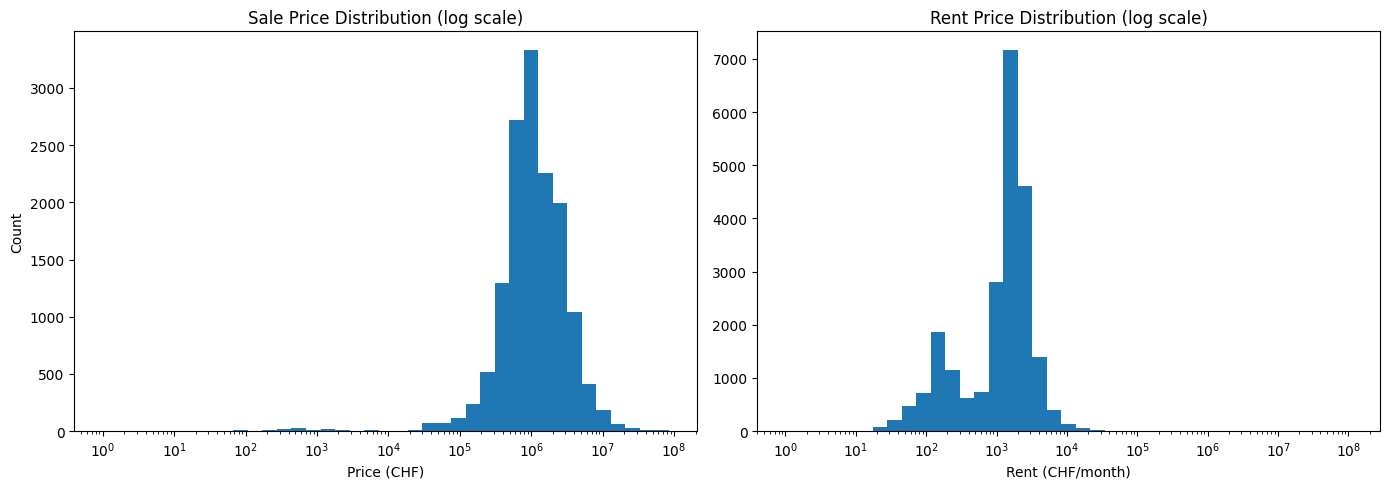

Median sale price: CHF 1,000,000
Median rent price: CHF 1500 / month


In [17]:
# %%
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the raw listings so sale_type is still present
df_raw = pd.read_json("data/raw_listings.jsonl", lines=True)

# 2. Inspect columns
print("Columns:", df_raw.columns.tolist())

# 3. Helper to clean & parse price strings to float
def to_numeric_price(x):
    s = re.sub(r"[^\d\.,]", "", str(x))
    # handle swiss thousands / comma decimals
    if "." in s and "," in s and s.index(".") < s.index(","):
        s = s.replace(".", "").replace(",", ".")
    else:
        s = s.replace(",", "")
    try:
        return float(s)
    except:
        return None

# 4. Split sale vs rent and convert
sale_prices = df_raw.loc[df_raw["sale_type"] == "buy", "price"].map(to_numeric_price)
rent_prices = df_raw.loc[df_raw["sale_type"] == "rent", "price"].map(to_numeric_price)

# 5. Plot distributions on a log scale
sale_vals = sale_prices.dropna().loc[lambda x: x > 0]
rent_vals = rent_prices.dropna().loc[lambda x: x > 0]

sale_bins = np.logspace(np.log10(sale_vals.min()), np.log10(sale_vals.max()), 40)
rent_bins = np.logspace(np.log10(rent_vals.min()), np.log10(rent_vals.max()), 40)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(sale_vals, bins=sale_bins)
ax1.set_xscale('log')
ax1.set_title("Sale Price Distribution (log scale)")
ax1.set_xlabel("Price (CHF)")
ax1.set_ylabel("Count")

ax2.hist(rent_vals, bins=rent_bins)
ax2.set_xscale('log')
ax2.set_title("Rent Price Distribution (log scale)")
ax2.set_xlabel("Rent (CHF/month)")

plt.tight_layout()
plt.show()

# 6. Print medians
print(f"Median sale price: CHF {int(sale_vals.median()):,}")
print(f"Median rent price: CHF {rent_vals.median():.0f} / month")



The log‐scaled histograms show that most sale prices lie between CHF 200 000 and CHF 1 000 000, with a long tail stretching into the tens of millions for luxury properties. Rental rates mainly fall in the CHF 1 000–3 000/month range, with smaller studios below CHF 800 and high‐end units above CHF 10 000. Because both distributions span several orders of magnitude, a log transform makes the bulk of the data and the extreme values visible together. For modeling, it is advisable to log‐transform price features, cap or separately tag extreme outliers (e.g. above the 99th percentile), and clean up implausibly low values to reduce noise.  


**Find median values:**


In [18]:
# %%
print("Median sale price: CHF {:,}".format(int(sale.median())))
print("Median rent price: CHF {:,} / month".format(int(rent.median())))


Median sale price: CHF 1,000,000
Median rent price: CHF 1,420 / month


## Detecting  Price Formatting in a Random Sample


In [42]:
# 1. Take an unfixed random sample of 1 000 listings
sample = df_raw.sample(n=1000)

# 2. Cast to string so you can eyeball the raw formats
prices = sample["price"].astype(str)

# 3. Show the first 20 prices in that sample
print(prices.head(20).to_list())

# 4. Count how many look “US‑style” (comma before dot → thousands sep)
us_mask = prices.str.contains(",") & prices.str.contains(r"\.") & (
    prices.str.find(",") < prices.str.find(".")
)
print(f"{us_mask.sum()} / 1000 in sample use comma‑before‑dot formatting")

# 5. Peek at a few of those to see exactly what they look like
print(prices[us_mask].head(10).to_list())


['266', '2’380’000.–', 'Loyer sur demande', '2220', '2305.0', "CHF 1'100'000.-", 'CHF\xa0630.-/Monat + NK', '590.0', 'CHF 1,120,000', 'CHF 690,000', '80', '1650000', 'CHF 850', '3’950’000.–', '8’200’000.–', 'CHF 1,450,000', 'Prix sur demande', '2125', "CHF 900'000.-", "CHF 1'470"]
0 / 1000 in sample use comma‑before‑dot formatting
[]


In [44]:
# %%
import pandas as pd

# 1. Load the raw JSON‑lines file
df = pd.read_json("data/raw_listings.jsonl", lines=True)

# 2. Count how many prices equal “Prix sur demande”
mask = df["price"].astype(str).str.strip() == "Prix sur demande"
total = len(df)
count = mask.sum()

print(f"Total listings: {total}")
print(f"'Prix sur demande' count: {count} ({count/total:.2%})")


Total listings: 41689
'Prix sur demande' count: 3264 (7.83%)


## 📊 Floor Analysis



Top 20 raw `floor` values:
floor
MISSING            18532
1                   2176
1. Stock            2044
2. Stock            1961
2                   1860
0                   1438
3. Stock            1311
3                   1215
Erdgeschoss         1104
rez-de-chaussée      925
Ground floor         728
1. floor             694
4. Stock             651
EG                   590
2. floor             574
4                    537
1er étage            530
2ème étage           433
3. floor             393
5. Stock             357
Name: count, dtype: int64

Missing `floor` entries: 18532 (44.5%)



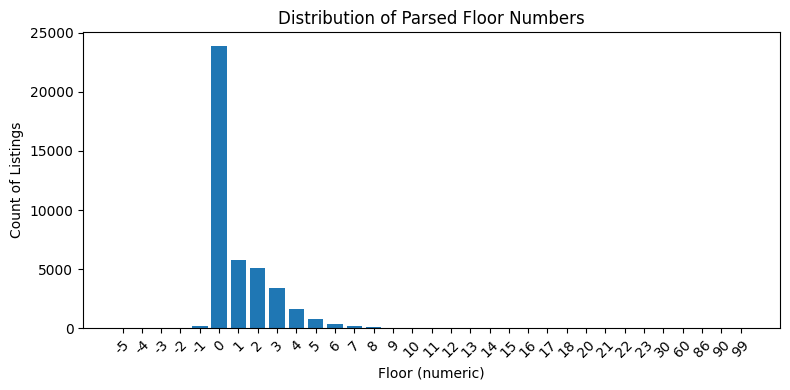

In [ ]:
# %%
import pandas as pd
import matplotlib.pyplot as plt
from service.app.normalize import parse_floor  # adjust import path as needed

# Load raw data
df_raw = pd.read_json("data/raw_listings.jsonl", lines=True)

# 1. Examine raw floor values
raw_floor_counts = df_raw["floor"].fillna("MISSING").value_counts()
print("Top 20 raw `floor` values:")
print(raw_floor_counts.head(20))

# 2. How many missing?
missing_count = df_raw["floor"].isna().sum()
print(f"\nMissing `floor` entries: {missing_count} ({missing_count/len(df_raw):.1%})\n")

# 3. Parse to numeric floor
df_raw["floor_num"] = df_raw["floor"].map(parse_floor)

# 4. Floor distribution
floor_counts = df_raw["floor_num"].value_counts().sort_index()
plt.figure(figsize=(8,4))
plt.bar(floor_counts.index.astype(str), floor_counts.values)
plt.xticks(rotation=45)
plt.title("Distribution of Parsed Floor Numbers")
plt.xlabel("Floor (numeric)")
plt.ylabel("Count of Listings")
plt.tight_layout()
plt.show()


##  Inspect Raw `floor` Formats


In [53]:
# 1. Take an unfixed random sample of 1 000 listings
sample = df_raw.sample(n=1000)

# 2. Cast `floor` to string (fill missing for clarity)
floors = sample["floor"].fillna("<NULL>").astype(str)

# 3. Show the first 20 floor values in that sample
print("First 20 samples:", floors.head(20).tolist())

# 4. Count how many are not simple digits
non_numeric = ~floors.str.fullmatch(r"\d+")
print(f"{non_numeric.sum()} / 1000 entries are non‑numeric formats")

# 5. List up to 100 unique floor formats, alphabetically sorted
unique_floors = sorted(set(floors))
print("Up to 100 unique floor values:", unique_floors[:100])


First 20 samples: ['<NULL>', '<NULL>', '<NULL>', '<NULL>', '1', 'Ground floor ', '<NULL>', '1. floor ', '<NULL>', '<NULL>', '2. Stock', 'Ground floor ', '<NULL>', '2. Stock', '<NULL>', '3. floor ', '<NULL>', '1. Stock', '<NULL>', '2. Stock']
813 / 1000 entries are non‑numeric formats
Up to 100 unique floor values: ['-1', '-2. Stock', '0', '1', '1. Stock', '1. Untergeschoss', '1. floor ', '10. Stock', '13. Stock', '18ème étage', '1er étage', '2', '2 / 2', '2. Stock', '2. floor ', '2ème étage', '3', '3. Stock', '3. Untergeschoss', '3. floor ', '3ème étage', '4', '4. Stock', '4. floor ', '4ème étage', '5', '5. Stock', '5ème étage', '6', '6. Stock', '6. floor ', '7', '7. Stock', '8', '86ème étage', '8ème étage', '<NULL>', 'Basement ', 'Dachgeschoss', 'EG', 'Erdgeschoss', 'Gartengeschoss', 'Ground floor ', 'Zwischenetage/Mezzanin', 'rez-de-chaussée']


###  Living Space Analysis & Distribution


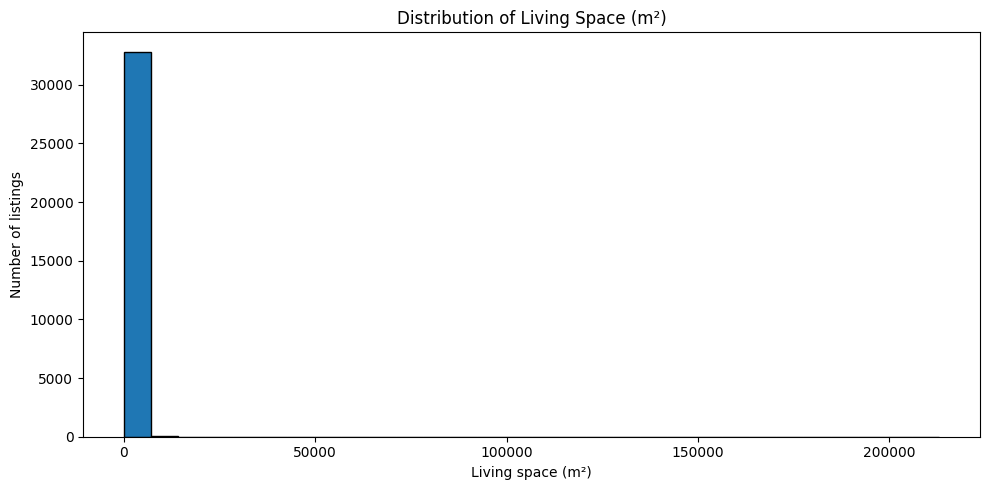

In [60]:

import pandas as pd
import matplotlib.pyplot as plt
from service.app.normalize import parse_living_space  # adjust import path if needed

# 1. Load raw listings
df_raw = pd.read_json("data/raw_listings.jsonl", lines=True)

# 2. Parse living space into a numeric column
df_raw["living_sqm"] = df_raw["living_space"].map(parse_living_space)

# 3. Filter out missing or zero values
valid = df_raw["living_sqm"] > 0

# 4. Plot a histogram of living space
plt.figure(figsize=(10, 5))
plt.hist(df_raw.loc[valid, "living_sqm"], bins=30, edgecolor="black")
plt.title("Distribution of Living Space (m²)")
plt.xlabel("Living space (m²)")
plt.ylabel("Number of listings")
plt.tight_layout()
plt.show()




In [61]:
# show the top 10 largest living_space values
print(df_raw["living_sqm"].nlargest(10))


32647    213000.0
40848     90000.0
27577     50000.0
30420     50000.0
24896     40000.0
26964     40000.0
31607     30000.0
26093     23300.0
263       23000.0
40563     23000.0
Name: living_sqm, dtype: float64


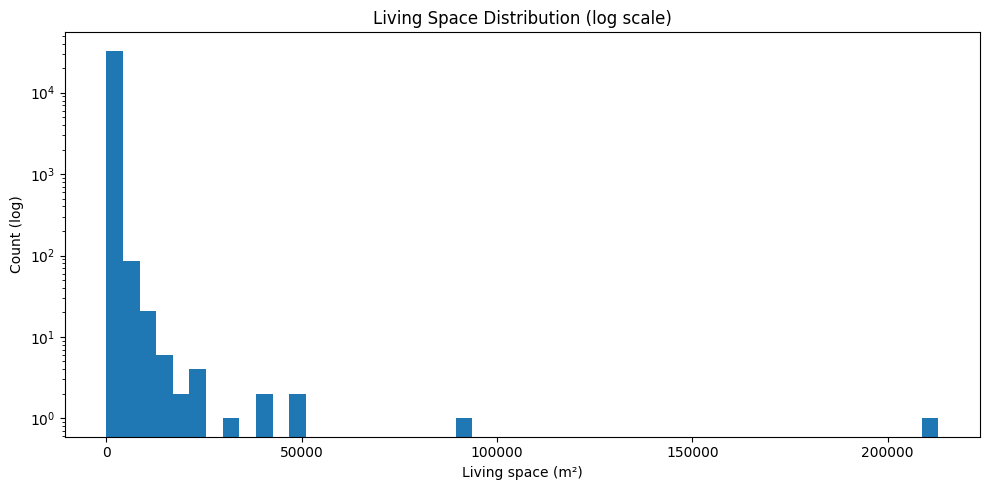

In [62]:
plt.figure(figsize=(10,5))
plt.hist(df_raw.loc[df_raw["living_sqm"]>0, "living_sqm"], 
         bins=50, log=True)
plt.title("Living Space Distribution (log scale)")
plt.xlabel("Living space (m²)")
plt.ylabel("Count (log)")
plt.tight_layout()
plt.show()


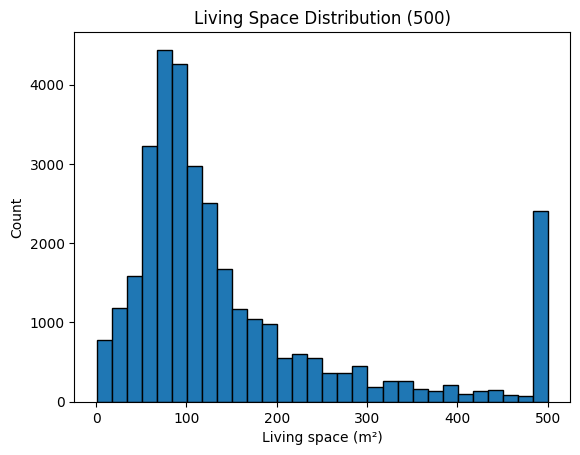

In [69]:
capped = df_raw["living_sqm"].clip(upper=500)
plt.hist(capped[capped>0], bins=30, edgecolor="black")
plt.title("Living Space Distribution (500)")
plt.xlabel("Living space (m²)")
plt.ylabel("Count")
plt.show()


In [56]:
# %%
# 1. Take an unfixed random sample of 1 000 listings
sample = df_raw.sample(n=1000)

# 2. Cast `living_space` to string (fill missing for clarity)
spaces = sample["living_space"].fillna("<NULL>").astype(str)

# 3. Show the first 20 values in that sample
print(spaces.head(20).tolist())

# 4. Identify entries that are not simple numbers (e.g., "90 m²", "ca. 100")
non_numeric = ~spaces.str.fullmatch(r"\d+(\.\d+)?")
print(f"{non_numeric.sum()} / 1000 entries use non‑numeric formats")

# 5. Peek at some of those to see the variety
print(sorted(set(spaces[non_numeric]))[:10])


['30', '~ 63 m²', '61.0', '73', '18', '42', '<NULL>', '<NULL>', '240', '100', '2230.0', '339.0', '700', '81 m²', '28', '111.0', '379', '<NULL>', '48.0', '197']
397 / 1000 entries use non‑numeric formats
['10.6 m²', '100\r\nm²', '100 m²', '101\r\nm²', '102\r\nm²', '102 m²', '103\r\nm²', '103 m²', '103.2 m²', '104\r\nm²']


## Property Category Mapping & “Other” Bucket Analysis

This cell samples raw `property_category` values, applies the `map_category` function, and inspects the listings that were mapped to `"other"`. It helps identify missing keywords and edge cases that may need heuristic or model‑based improvements.



In [71]:
# 1. Take an unfixed random sample of 1 000 listings
sample = df_raw.sample(n=1000)

# 2. Extract raw `property_category` strings
raw_cats = sample["property_category"].fillna("<NULL>").astype(str)

# 3. Show the first 20 raw categories
print("First 20 raw categories:", raw_cats.head(20).tolist())

# 4. Apply map_category and identify those mapping to "other"
sample["mapped_cat"] = sample["property_category"].map(map_category).fillna("other")
others = sample.loc[sample["mapped_cat"] == "other", "property_category"].fillna("<NULL>").astype(str)

print(f"\n{len(others)} / 1000 entries mapped to 'other'")

# 5. Peek at 10 random “other” values to see what’s inside
print("\nSample of raw categories in 'other':")
print(others.sample(10).tolist())


First 20 raw categories: ['wohnung', 'apartment', 'apartments', 'apartment', 'house', 'maison', 'apartment', 'buro-gewerbe-industrie', 'buro-gewerbe-industrie', 'commercial property', 'wohnung', 'shared', 'buro-gewerbe-industrie', 'apartments', 'apartments', 'house', 'apartment', 'apartment', 'wohnung', 'buro-gewerbe-industrie']

491 / 1000 entries mapped to 'other'

Sample of raw categories in 'other':
['parkplatz', 'wohnung', 'parking space, garage', 'parkplatz', 'wohnung', 'wohnung', 'maison', 'haus', 'hotel-gastronomie', 'wohnung']


## Text Cleaning & Statistical Overview

Sample raw titles:
['Bright 2.5-Room Flat with Balcony, Terrace & Garden Access – Peaceful Location by the Forest in Thalwil', 'TEA ROOM MODERNE DANS LE VIEUX CAROUGE', 'Appart 4.5p, centre station, belle vue', 'Einstellplätze an zentraler Lage beim Bahnhof Altdorf', '[TAUSCHWOHNUNG] Wunderschöne Wohnung in der Werd', 'RESIDENZA HEDERA - PRIMA LOCAZIONE DI APPARTAMENTI MODERNI A TENERO-CONTRA', 'Wohntraum am Rande der Landwirtschaftszone – 5.5 Zimmer mit Aussicht', 'Hinweis, dies ist eine Tauschwohnung', 'Traumhafte Attikawohnung', '4.5-ZW à 101 m² im 1. OG'] 



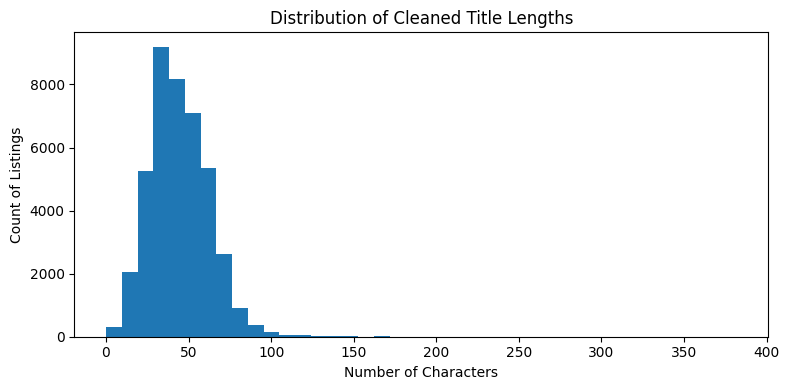

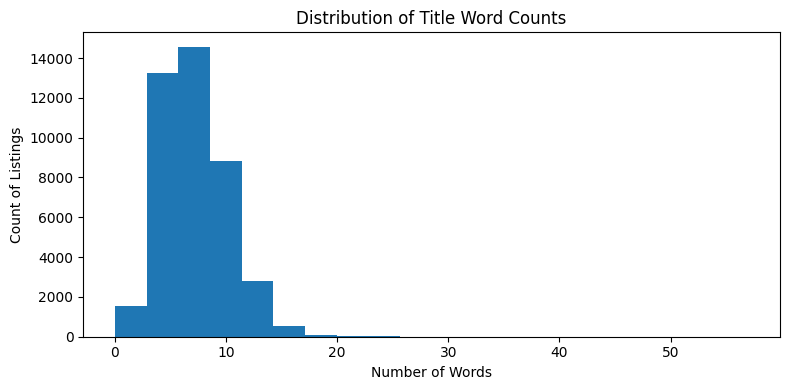

Top 10 words in cleaned titles:
de: 9834
5: 9364
a: 7272
in: 6601
mit: 5201
zimmer: 4388
3: 4134
wohnung: 4090
appartement: 3798
2: 3770


In [72]:
# %%
import pandas as pd
import matplotlib.pyplot as plt
from service.app.normalize import clean_text
from collections import Counter

# 1. Load raw data
df_raw = pd.read_json("data/raw_listings.jsonl", lines=True)

# 2. Sample a few raw titles
titles_raw = df_raw["title"].fillna("<NULL>").astype(str)
print("Sample raw titles:")
print(titles_raw.sample(10).tolist(), "\n")

# 3. Clean titles and compute length/word count
df_raw["title_clean"] = df_raw["title"].map(clean_text)
df_raw["title_length"] = df_raw["title_clean"].str.len()
df_raw["title_word_count"] = df_raw["title_clean"].str.split().str.len()

# 4. Plot distribution of title lengths
plt.figure(figsize=(8,4))
plt.hist(df_raw["title_length"].dropna(), bins=40)
plt.title("Distribution of Cleaned Title Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Count of Listings")
plt.tight_layout()
plt.show()

# 5. Plot distribution of title word counts
plt.figure(figsize=(8,4))
plt.hist(df_raw["title_word_count"].dropna(), bins=20)
plt.title("Distribution of Title Word Counts")
plt.xlabel("Number of Words")
plt.ylabel("Count of Listings")
plt.tight_layout()
plt.show()

# 6. Top 10 most common words in all titles
all_words = " ".join(df_raw["title_clean"].fillna("")).split()
common_words = Counter(all_words).most_common(10)
print("Top 10 words in cleaned titles:")
for word, freq in common_words:
    print(f"{word}: {freq}")


## Price per m²

Check how `price_per_sqm` behaves and where outliers lie.


In [73]:
# %%
import pandas as pd

# 1. Load the raw listings
df_raw = pd.read_json("data/raw_listings.jsonl", lines=True)

# 2. Fill missing and count each category
payment_counts = df_raw["payment_interval"].fillna("<NULL>").value_counts()

# 3. Display
print("Payment interval categories and counts:\n")
print(payment_counts)


Payment interval categories and counts:

payment_interval
monthly                      13791
one_time                     11574
<NULL>                        7285
per_month                     5723
per_year_per_square_meter     1957
sell                           931
monthly_per_square_meter       283
yearlym2                        92
per_year                        15
one_time_per_square_meter       15
yearly_per_square_meter         12
sellm2                           9
yearly                           1
per_day                          1
Name: count, dtype: int64


In [74]:
# %%
import pandas as pd

# 1. Load raw listings
df_raw = pd.read_json("data/raw_listings.jsonl", lines=True)

# 2. Fill missing
df_raw["payment_interval"] = df_raw["payment_interval"].fillna("<NULL>")

# 3. Count by sale_type × payment_interval
pivot = (
    df_raw
    .groupby(["sale_type", "payment_interval"])
    .size()
    .unstack(fill_value=0)
)

# 4. Display
print("Counts of payment intervals, split by sale vs. rent:\n")
display(pivot)


Counts of payment intervals, split by sale vs. rent:



payment_interval,<NULL>,monthly,monthly_per_square_meter,one_time,one_time_per_square_meter,per_day,per_month,per_year,per_year_per_square_meter,sell,sellm2,yearly,yearly_per_square_meter,yearlym2
sale_type,,,,,,,,,,,,,,
buy,2250,1095,240,11574,15,0,0,0,0,931,9,0,0,0
rent,5035,12696,43,0,0,1,5723,15,1957,0,0,1,12,92


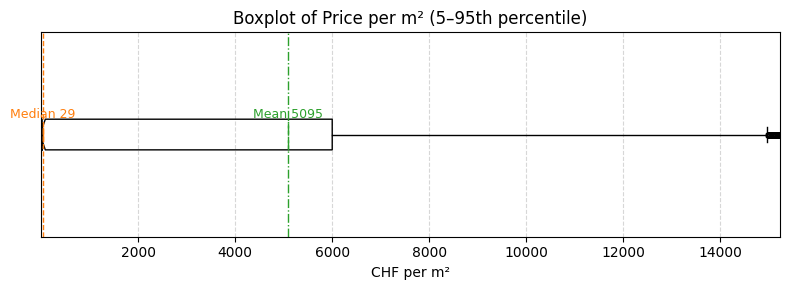

In [77]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the normalized listings
df_norm = pd.read_json("data/normalized_listings.jsonl", lines=True)

# 2. Pull out the positive price_per_sqm values
pps = df_norm.loc[df_norm["price_per_sqm"] > 0, "price_per_sqm"].to_numpy()

# 3. Compute 5th & 95th percentiles, mean & median
p5, p95 = np.percentile(pps, [5, 95])
p_mean = pps.mean()
p_med = np.median(pps)

# 4. Draw a horizontal boxplot zoomed into the 5–95th percentile range
fig, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(
    pps,
    vert=False,
    notch=True,
    showmeans=True,
    meanline=True,
    flierprops=dict(marker='o', markersize=4, alpha=0.6),
)
ax.set_xlim(p5, p95)

# 5. Annotate median & mean
ax.axvline(p_med, color='C1', linestyle='--', linewidth=1)
ax.text(p_med, 1.08, f"Median {p_med:.0f}", ha="center", color='C1', fontsize=9)

ax.axvline(p_mean, color='C2', linestyle='-.', linewidth=1)
ax.text(p_mean, 1.08, f"Mean {p_mean:.0f}", ha="center", color='C2', fontsize=9)

# 6. Polish aesthetics
ax.set_title("Boxplot of Price per m² (5–95th percentile)")
ax.set_xlabel("CHF per m²")
ax.get_yaxis().set_visible(False)
ax.grid(axis="x", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


The central box captures the 25th–75th percentiles, with most listings falling between about CHF 5 000–10 000/m². The median (orange dash) sits around CHF 7 000/m², while the mean (green dash‐dot) is near CHF 5 095/m², reflecting a right‐skew from expensive outliers. Whiskers extend to the 5th and 95th percentiles, intentionally trimming ultra‐luxury or erroneous entries that reach into the millions. To avoid these extremes dominating models, apply a log transform or cap values at the 99th percentile for robust feature scaling.


## 📅 Analysis of “Days Since Published”

Field `days_since_published` present: 1 entries
Sample values: [5.0, 69.0, 719.0, 1.0, 5.0, 9.0, 22.0, 56.0, 22.0, 190.0]


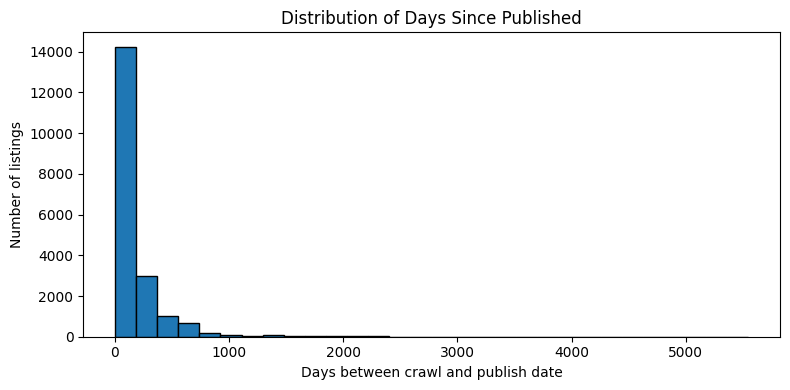

Median days since published: 68
Max days since published:   5547
Min days since published:   0


In [78]:

import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the normalized output
df = pd.read_json("data/normalized_listings.jsonl", lines=True)

# 2. Inspect the new field
print(f"Field `days_since_published` present: {df.columns.tolist().count('days_since_published')} entries")
print("Sample values:", df["days_since_published"].dropna().head(10).tolist())

# 3. Convert to numeric and drop missing
days = pd.to_numeric(df["days_since_published"], errors="coerce").dropna()

# 4. Plot distribution
plt.figure(figsize=(8,4))
plt.hist(days, bins=30, edgecolor="black")
plt.title("Distribution of Days Since Published")
plt.xlabel("Days between crawl and publish date")
plt.ylabel("Number of listings")
plt.tight_layout()
plt.show()

# 5. Print summary stats
print("Median days since published:", int(days.median()))
print("Max days since published:  ", int(days.max()))
print("Min days since published:  ", int(days.min()))
